## Libraries

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
%matplotlib inline

### Loading data folder where our dataset 
with `os.listdir(data_dir)[0:10]` we look for all the directories inside `data` folder

In [2]:
data_dir = "./data"
print(os.listdir(data_dir)[0:10])

['val', 'test', 'train']


#### Directories inside `data/train/`

In [3]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['val', 'test', 'train']
['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton plant', 'fresh cotton leaf']


In [4]:
diseased_cotton_leaf = os.listdir(data_dir + "/train/diseased cotton leaf")
print(f"#Number of training examples for diseased cotton leaf: {len(diseased_cotton_leaf)}")
print(diseased_cotton_leaf[0:5])



#Number of training examples for diseased cotton leaf: 288
['dis_leaf (251)_iaip.jpg', 'dis_leaf (292)_iaip.jpg', 'dis_leaf (156)_iaip.jpg', 'dis_leaf (154)_iaip.jpg', 'dis_leaf (196)_iaip.jpg']


### Number of images for each class inside `training` directory

In [5]:
for i in classes:
    result = os.listdir(data_dir + "/train/" + i)
    print(f"Number of images in {i} = {len(result)}")

Number of images in diseased cotton leaf = 288
Number of images in diseased cotton plant = 815
Number of images in fresh cotton plant = 421
Number of images in fresh cotton leaf = 427


## Data preprocessing
1. `image_size = 32`:

    - This specifies that the images will be resized to 32x32 pixels.
    - The images in the dataset may be of varying sizes, but they will all be resized to 32x32 using this value.

2. `batch_size = 128`:
    - This sets the number of images processed in a batch during training/validation. A batch size of 128 means that during each iteration of training or evaluation, 128 images will be fed into the model.

3. `stats = ((0.4914,0.4822,0.4465),(0.2022,0.1994,0.2010))`:
    - This tuple contains the mean and standard deviation values for normalization. These statistics are typically computed over the entire training dataset.
        - Mean: `(0.4914, 0.4822, 0.4465)` — This represents the average value for each color channel (RGB).
        - Standard deviation: `(0.2022, 0.1994, 0.2010)` — This represents the standard deviation for each color channel (RGB).
    Normalization is performed to scale the input images to have zero mean and unit variance. The normalization formula for each pixel is: `normalized pixel value = (pixel value - mean) / std deviation`

#### Why These Transformations?
- `Resize and Crop`: Resizing and cropping ensure that all images are of consistent size, which is important for neural networks since they require fixed input dimensions.

- `ToTensor`: Converts images into a tensor so they can be used in a PyTorch model. PyTorch models expect input in the form of a tensor (instead of a regular image format like PNG or JPEG).

- `Normalize`: Helps to standardize the input data, making it easier for the model to learn. When the input images have very different ranges, the model can struggle to learn effectively. Normalizing using the mean and standard deviation of the dataset ensures that the images have consistent value ranges.

### IMPORTANT QUESTIONS: 
- `Why do we normalize each pixel value?`
- `How were mean and sd were calculated from each color pixel?`


### Step-by-Step Guide to Calculate Mean and Standard Deviation
- Load the Dataset: First, you need to load the dataset using ImageFolder or any other method that provides access to your image data.

- Iterate Through the Dataset: You need to iterate through all the images and compute the mean and standard deviation for each color channel.

- Compute the Mean and Standard Deviation: While iterating through the images, accumulate the sum of pixel values and the sum of squared pixel values for each color channel. Afterward, use these accumulations to calculate the mean and standard deviation.



In [6]:
image_size = 32
batch_size = 128
stats = ((0.4914, 0.4822, 0.4465), (0.2022, 0.1994, 0.2010))

In [7]:
train_ds = ImageFolder(data_dir + "/train", transform=T.Compose(
    [
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(), T.Normalize(*stats)
    ]
))

val_ds = ImageFolder(data_dir + "/val", transform=T.Compose(
    [
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(), T.Normalize(*stats)
    ]
))

In [8]:
train_ds

Dataset ImageFolder
    Number of datapoints: 1951
    Root location: ./data/train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(32, 32))
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2022, 0.1994, 0.201))
           )

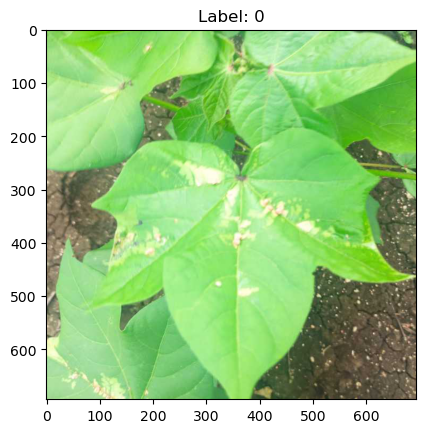

In [9]:
unnormalized_ds = ImageFolder(data_dir + "/train")
img, label = unnormalized_ds[0]
plt.imshow(img)
plt.title(f"Label: {label}")  # Display the label of the image
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7141255..2.53779].


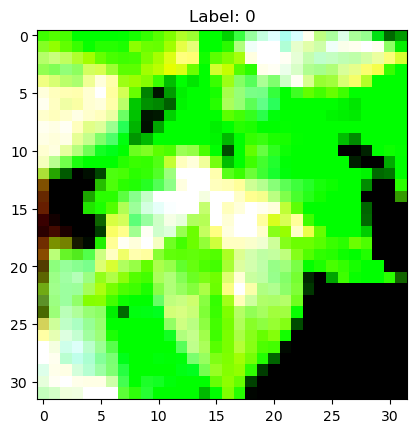

In [10]:
# Get one image and its label from the train dataset
img, label = train_ds[0]  # Get the first image and label

# Convert tensor to numpy for displaying (from CxHxW to HxWxC)
img = img.permute(1, 2, 0).numpy()

# Display the normalized image
plt.imshow(img)
plt.title(f"Label: {label}")  # Display the label of the image
plt.show()

### 1. DataLoader:
- `DataLoader` is a utility provided by PyTorch to load datasets in mini-batches, which is important for training deep learning models. It allows efficient handling of large datasets by loading data in parallel and shuffling it for each epoch.
- It takes a dataset as input and outputs batches of data that can be fed into the model.
### 2. Arguments of DataLoader
For `train_dl`
```python
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
```

- `train_ds`: This is the training dataset that you want to load. It is typically an instance of a dataset class like ImageFolder, where each image and its label are returned when accessed.

- `batch_size`: This defines how many samples will be in each batch. For example, if batch_size = 64, it means that the DataLoader will return batches of 64 samples each time it is iterated over.

- `shuffle=True`: This tells the DataLoader to shuffle the data after each epoch. Shuffling is important to prevent the model from learning patterns based on the order of the data, which could lead to overfitting or poor generalization.

- `num_workers=3` : This specifies how many subprocesses to use for data loading. Using multiple workers allows the data to be loaded in parallel, improving performance when loading large datasets. Here, 3 subprocesses will be used to load the data.

- `pin_memory=True`: This flag indicates whether or not to pin memory. When set to True, it allows the DataLoader to load the data into pinned (locked) memory, which can speed up data transfer to the GPU. This is especially useful if you're training on a GPU, as it reduces the time it takes to move the data from CPU to GPU memory.

For `val_dl`
```python
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
```
- `val_ds`: This is the validation dataset, typically used for evaluating the model during training. It works similarly to train_ds but is not used for training.

- `batch_size*2` : The batch size is doubled here (batch_size*2). This is often done during validation because the model is not being updated during validation, so you can afford to process more data at once, which can improve validation performance by reducing the overhead of batch processing.

- `num_workers=4` : Similar to train_dl, but here, 4 subprocesses are used for loading the validation data in parallel. This might be increased because validation data is usually smaller and requires fewer transformations.

- `pin_memory=True` : Just like with the training DataLoader, pinning memory during validation helps speed up the data transfer to the GPU.

In [11]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3,pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4,pin_memory=True)

In [12]:
def denorm(img_tensors):
    return img_tensors*stats[1][0]+ stats[0][0]

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))
def show_batch(dl,nmax=64):
    for images, _ in dl:
        show_images(images,nmax)
        break
    

In [14]:
show_batch(train_dl)
torch.cuda.empty_cache()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0124944].


In [15]:
show_batch(val_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0124944].
